# Convolution

https://docs.e3nn.org/en/stable/guide/convolution.html

$$
f'_i = \frac{1}{\sqrt{z}} \sum_{j \in \partial(i)} \; f_j \; \otimes\!(h(\|x_{ij}\|)) \; Y(x_{ij} / \|x_{ij}\|)
$$

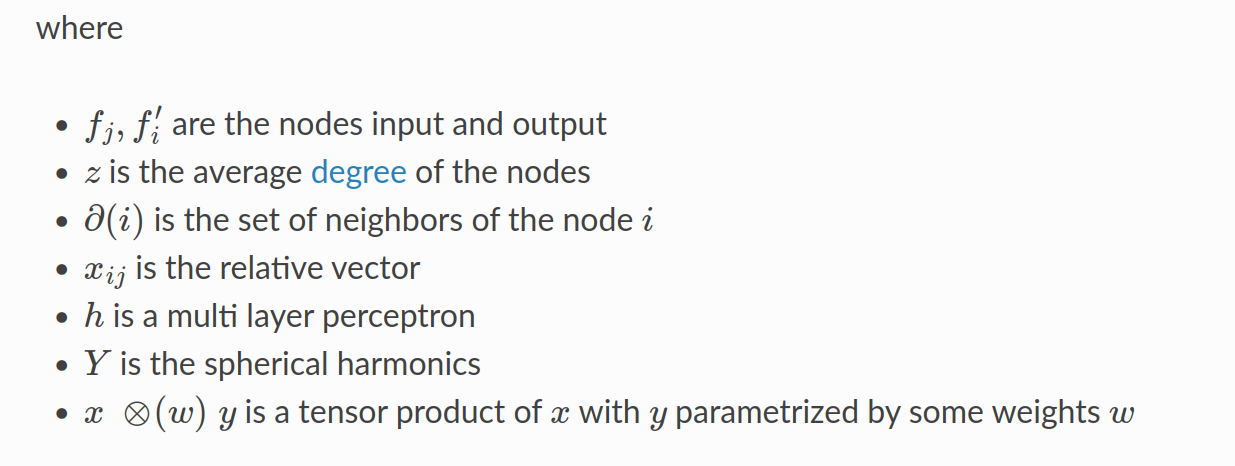

In [2]:
import torch
from torch_cluster import radius_graph
from torch_scatter import scatter
from e3nn import o3, nn
from e3nn.math import soft_one_hot_linspace
import matplotlib.pyplot as plt

Let’s first define the irreps of the input and output features.

In [3]:
irreps_input = o3.Irreps("10x0e + 10x1e")
irreps_output = o3.Irreps("20x0e + 10x1e")

And create a random graph using random positions and edges when the relative distance is smaller than max_radius.

In [4]:
# create node positions
num_nodes = 100
pos = torch.randn(num_nodes, 3)  # random node positions

# create edges
max_radius = 1.8
# edge_src-edge_dst ペアのノード間がエッジで結ばれている。
edge_src, edge_dst = radius_graph(pos, max_radius, max_num_neighbors=num_nodes - 1)

print(edge_src.shape)

edge_vec = pos[edge_dst] - pos[edge_src]

# z
num_neighbors = len(edge_src) / num_nodes
num_neighbors

torch.Size([3444])


34.44

`irreps_input="10x0e+10x1e"` なので、40 次元ベクトルが各ノードに対して作られる。`randn` の引数のなかの `-1` はこの 40 を示しているので、`randn` を使用するときは必ず最後に `-1` をつけることになる。（docstring 参照）

In [5]:
f_in = irreps_input.randn(num_nodes, -1)
f_in.shape

torch.Size([100, 40])

In [6]:
# torch.pow -> テンソルの各要素を冪乗
f_in.pow(2).mean()  # should be close to 1

tensor(0.9854)

Let's start with
$$
Y(x_{ij} / \|x_{ij}\|)
$$

In [11]:
irreps_sh = o3.Irreps.spherical_harmonics(lmax=2)
print(irreps_sh)
print(edge_vec.shape)

sh = o3.spherical_harmonics(irreps_sh, edge_vec, normalize=True, normalization='component')
# normalize=True ensure that x is divided by |x| before computing the sh

print(sh.shape)
sh.pow(2).mean()  # should be close to 1

1x0e+1x1o+1x2e
torch.Size([3444, 3])
torch.Size([3444, 9])


tensor(1.)

In [12]:
print(irreps_input)
print(irreps_output)
print(irreps_sh)

10x0e+10x1e
20x0e+10x1e
1x0e+1x1o+1x2e


FullyConnectedTensorProduct(10x0e+10x1e x 1x0e+1x1o+1x2e -> 20x0e+10x1e | 400 paths | 400 weights) needs 400 weights


/home/keiyu/workspace/e3nn/.venv/lib/python3.10/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(


(<Figure size 640x480 with 1 Axes>, <Axes: >)

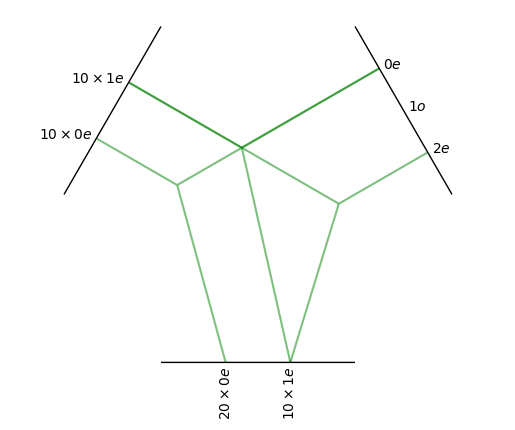

In [13]:
tp = o3.FullyConnectedTensorProduct(irreps_input, irreps_sh, irreps_output, shared_weights=False)

print(f"{tp} needs {tp.weight_numel} weights")

tp.visualize()

In [8]:
type(irreps_sh)

e3nn.o3._irreps.Irreps

## implement weight $h(\|x_{ij}\|)$

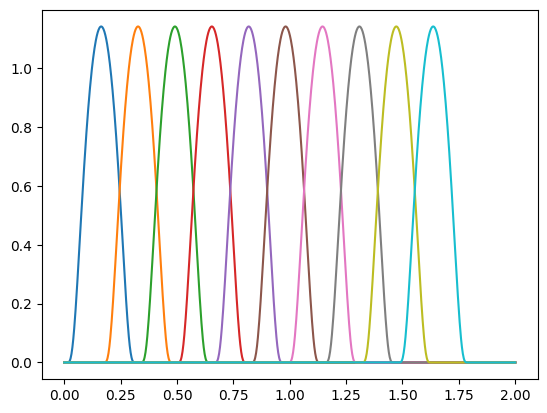

In [15]:
num_basis = 10

x = torch.linspace(0.0, 2.0, 1000)
y = soft_one_hot_linspace(
    x,
    start=0.0,
    end=max_radius,
    number=num_basis,
    basis='smooth_finite',
    cutoff=True,
)

plt.plot(x, y)

compute
$$
\; f_j \; \otimes\!(h(\|x_{ij}\|)) \; Y(x_{ij} / \|x_{ij}\|)
$$

In [28]:
edge_length_embedding = soft_one_hot_linspace(
    edge_vec.norm(dim=1),
    start=0.0,
    end=max_radius,
    number=num_basis,
    basis='smooth_finite',
    cutoff=True,
)
edge_length_embedding = edge_length_embedding.mul(num_basis**0.5)

print(edge_length_embedding.shape)
edge_length_embedding.pow(2).mean()  # the second moment

torch.Size([3444, 10])


tensor(0.8909)

In [29]:
tp

FullyConnectedTensorProduct(10x0e+10x1e x 1x0e+1x1o+1x2e -> 20x0e+10x1e | 400 paths | 400 weights)

In [34]:
fc = nn.FullyConnectedNet([num_basis, 16, tp.weight_numel], torch.relu)  # dense layer 10 -> 16 -> 400 = h(||x_{ij}||)
weight = fc(edge_length_embedding)

print(weight.shape)
print(len(edge_src), tp.weight_numel)

# For a proper notmalization, the weights also need to be mean 0
print(weight.mean(), weight.std())  # should close to 0 and 1

torch.Size([3444, 400])
3444 400
tensor(-0.0470, grad_fn=<MeanBackward0>) tensor(0.7845, grad_fn=<StdBackward0>)


In [45]:
print(f_in[edge_src].shape)
print(sh.shape)
print(weight.shape)
summand = tp(f_in[edge_src], sh, weight)
print(summand.shape)

torch.Size([3444, 40])
torch.Size([3444, 9])
torch.Size([3444, 400])
torch.Size([3444, 50])


compute
$$
\sum_{j \in \partial(i)} 
$$

In [56]:
f_out = scatter(summand, edge_dst, dim=0, dim_size=num_nodes)

f_out = f_out.div(num_neighbors**0.5)

f_out.pow(2).mean()  # should be close to 1

tensor(0.6076, grad_fn=<MeanBackward0>)

Now we can put everything into a function

In [57]:
def conv(f_in, pos):
    edge_src, edge_dst = radius_graph(pos, max_radius, max_num_neighbors=len(pos) - 1)
    edge_vec = pos[edge_dst] - pos[edge_src]
    sh = o3.spherical_harmonics(irreps_sh, edge_vec, normalize=True, normalization='component')
    emb = soft_one_hot_linspace(edge_vec.norm(dim=1), 0.0, max_radius, num_basis, basis='smooth_finite', cutoff=True).mul(num_basis**0.5)
    return scatter(tp(f_in[edge_src], sh, fc(emb)), edge_dst, dim=0, dim_size=num_nodes).div(num_neighbors**0.5)

Now we can check the equivariance

In [59]:
rot = o3.rand_matrix()
D_in = irreps_input.D_from_matrix(rot)
D_out = irreps_output.D_from_matrix(rot)

# rotate before
f_before = conv(f_in @ D_in.T, pos @ rot.T)

# rotate after
f_after = conv(f_in, pos) @ D_out.T

torch.allclose(f_before, f_after, rtol=1e-4, atol=1e-4)

True